# Noise2Void - 2D Example for SEM data

Strongly inspired from https://github.com/juglab/n2v/tree/main/examples/2D/denoising2D_SEM

In [63]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Download Example Data

Data by Anneke Kremer
Thanks!


In [64]:
# List the files to analyze
input_folder = '/dodrio/scratch/projects/2024_300/training/n2v/'
output_folder = '/dodrio/scratch/projects/2024_300/<YOUR_NAME>/n2v' #TO CHANGE
os.makedirs(output_folder, exist_ok=True)
model_folder = os.path.join(output_folder, 'model')
os.makedirs(model_folder, exist_ok=True)

# Training Data Preparation

For training we load **one** set of low-SNR images and use the N2V_DataGenerator to extract training **X** and validation **X_val** patches.


In [65]:
training_path = os.path.join(input_folder, 'training')

In [66]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [ ]:
# We load all the '.tif' files from the 'data' directory.
# If you want to load other types of files see the RGB example.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = training_path)

# Let's look at the shape of the images.
print(imgs[0].shape,imgs[1].shape)
# The function automatically added two extra dimensions to the images:
# One at the beginning, is used to hold a potential stack of images such as a movie.
# One at the end, represents channels.

In [ ]:
# Lets' look at the images.
# We have to remove the added extra dimensions to display them as 2D images.
plt.imshow(imgs[0][0,...,0], cmap='gray')
plt.show()

plt.imshow(imgs[1][0,...,0], cmap='gray')
plt.show()

In [ ]:
# We will use the first 2 images to extract training patches and store them in 'X'
patch_shape = (64, 64)
X = datagen.generate_patches_from_list(imgs[:2], shape=patch_shape)

# We will use the third image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[2:], shape=patch_shape)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches would also allow us to split them into a training and validation set 
# per image. This might be an interesting alternative to the split we performed above.

In [ ]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

In [ ]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch')
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch')


## Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the `N2VConfig` constructor for a description of all parameters.

When creating the config-object, we provide the training data **X**. From **X** we extract `mean` and `std` that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from **X**.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased `train_batch_size` and `batch_norm`. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter `n2v_manipulator` with default value `'uniform_withCP'`. Most pixel manipulators will compute the replacement value based on a neighborhood. With `n2v_neighborhood_radius` we can control its `size`.

Other pixel manipulators:

    normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
    normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = `n2v_neighborhood_radius`
    normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
    identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via `n2v_perc_pix`.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.
*Note:* Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

*Warning:* to make this example notebook execute faster, we have set train_epochs to only *20*.
For better results we suggest *100* to *200* `train_epochs`.


In [72]:
train_epochs = 20

In [ ]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=train_epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

In [74]:
# a name used to identify the model
model_name = 'n2v_2D_sem'
# the base directory in which our model will live
#basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=model_folder)

## Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

## After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


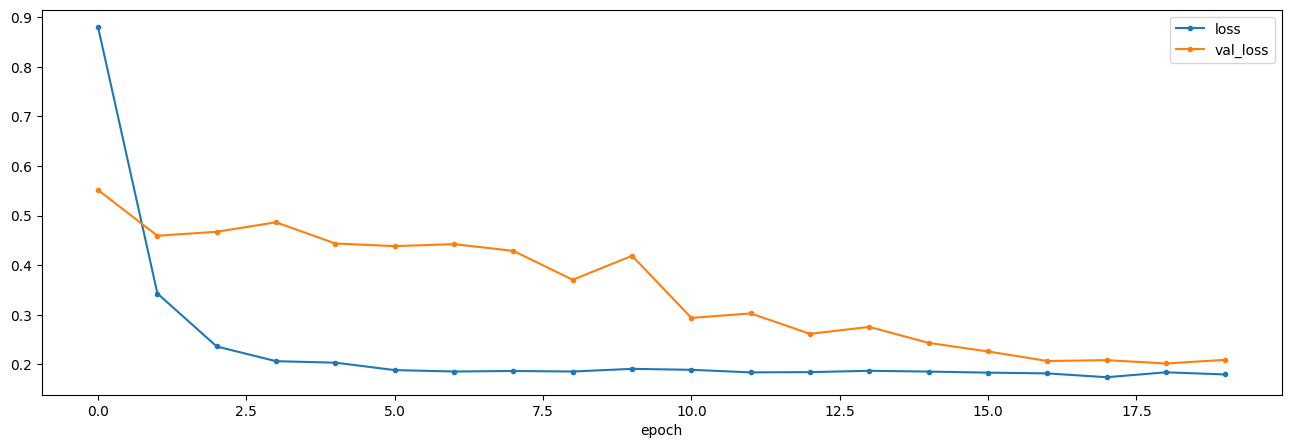

In [76]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [ ]:
model_bioimage_folder = os.path.join(model_folder, 'bioimage_model_zoo')
os.makedirs(model_bioimage_folder, exist_ok=True)


model.export_TF(name='Noise2Void - 2D SEM Example', 
                description='This is the 2D Noise2Void example trained on SEM data in python.', 
                authors=["Your Name", "Another Name"],
                test_img=X_val[0,...], axes='YXC',
                patch_shape=patch_shape,
                result_path = model_bioimage_folder)